In [24]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime
import inspect
from utils.constants import *


In [2]:
repository = DataRepository()

Connected to MySQL Server version  5.7.39-42-log


### Configuration

The configuration defines under what circumstances the experiment was executed under.

In [52]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 40
max_battery = 80

between = 0
duration = 1

language = "CSharp"

env = "PROD"

limit = 200

### Operating System

Here the different operation systems used in the experiments are defined

In [181]:
## OS
os = [
    WINDOWS_OS,
    # LINUX_OS
]

short_os = {
    WINDOWS_OS : "win",
    LINUX_OS : "lin"
}

### Test Cases

Here the different test cases executed during the experiments are defined

In [195]:
## Test cases
test_cases = [
    IDLE_CASE,
    # DINING_PHILOSOPHERS,
    BINARY_TREE,
    # # REVERSE_COMPLEMENT
    # FANNKUCH_REDUX,
    # NBODY,
    # FASTA
]

short_test_case = {
    IDLE_CASE : "idle",
    DINING_PHILOSOPHERS : "din",
    BINARY_TREE : "bin",
    REVERSE_COMPLEMENT : "rev",
    FANNKUCH_REDUX : "fann",
    NBODY : "nbody",
    FASTA : "fasta"
}

### Profilers

Here the different profilers used to measure the energy consumption of the test cases are defined

In [196]:
## Profilers
profilers = [
    INTEL_POWER_GADGET,
    # RAPL,
    HARDWARE_MONITOR,
    CLAMP,
    # E3
]

short_profilers = {
    INTEL_POWER_GADGET : "IPG",
    RAPL : "RA",
    HARDWARE_MONITOR : "HWM",
    E3 : "E3",
    CLAMP : "CL"
}

### DUT

Here the different Devices Under Tests (DUT) are defined

In [197]:
## DUT
duts = [
    SURFACE_4_PRO,
    SURFACE_BOOK,
    POWER_KOMPLETT
]

short_duts = {
    SURFACE_4_PRO : "pro",
    SURFACE_BOOK : "book",
    POWER_KOMPLETT : "pow",
}

dut_version = {
    SURFACE_BOOK : {
            WINDOWS_OS : 6,
            LINUX_OS : 1
        },
    SURFACE_4_PRO : {
        WINDOWS_OS : 12,
        LINUX_OS : 1,
    },
    POWER_KOMPLETT : {
        WINDOWS_OS : 8,
        LINUX_OS : 1,
    }
}

### Types

Here the different types of energy measurements are defined

In [198]:
## Types
comparison_types = [PACKAGE_TOTAL, DRAM_TOTAL,CORE_TOTAL]


In [199]:
def get_dynamic_energy(
    d, o, p, energy_type, duration, energy_consumption, dynamic_energy, per_unit=1000
):
    dynamic_energy_index = dynamic_energy[d][o][p]

    dynamic_energy_consumption = dynamic_energy_index[energy_type]
    dynamic_duration = dynamic_energy_index["duration"]

    if dynamic_duration == 0 or duration == 0:
        return 0

    dynamic_energy_per_unit = (per_unit / dynamic_duration) * dynamic_energy_consumption
    energy_per_unit = (per_unit / duration) * energy_consumption

    return energy_per_unit - dynamic_energy_per_unit

In [94]:
def default_func(exp, value):
    return True


def get_consumption(
    d,
    o,
    p,
    t,
    value_type,
    func_parameter,
    data,
    dynamic_energy,
    func=default_func,
    get_dynamic=True,
):
    try:
        data_points = data[d][o][t][p]["experiment"].experiments
    except Exception as e:
        return 0, 0, 0, 0, 0, 0

    duration = [
        exp.duration / exp.runs for exp in data_points if func(exp, func_parameter)
    ]
    length = len(duration)

    if value_type == PACKAGE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(x.TrueRMS, x.duration) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerPacketTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == DRAM_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeDramEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(0, 0) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerMemoryTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == CORE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [
                (x.TrueRMS, x.duration) for x in data_points if func(x, func_parameter)
            ]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerCoresTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    else:
        raise Exception(f"{value_type} not implmeneted")

    if get_dynamic:
        dynamic_values = []

        for value in values:
            dynamic_values.append(
                get_dynamic_energy(d, o, p, value_type, value[1], value[0], dynamic_energy)
            )

        if length == 0:
            return 0, 0, 0, 0, 0, 0

        return (
            length,
            sum(dynamic_values) / length,
            np.std(dynamic_values),
            min(dynamic_values),
            max(dynamic_values),
            sum(duration) / length,
        )
    else:
        only_values = [x[0] for x in values]
        return (
            length,
            sum(only_values) / length,
            np.std(only_values),
            min(only_values),
            max(only_values),
            sum(duration) / length,
        )

In [95]:
def initialize_dynamic_energy(data):
    dynamic_energy = {}
    for d in duts:
        dynamic_energy[d] = {}
        for o in os:
            dynamic_energy[d] = {}
            dynamic_energy[d][o] = {}
            for p in profilers:
                dynamic_energy[d][o][p] = {}
                for types in comparison_types:
                    t = IDLE_CASE
                    
                    count, average, _, min_value, max_value, duration = get_consumption(
                        d, o, p, t, types, "", data, get_dynamic=False)
                    dynamic_energy[d][o][p][types] = average
                    dynamic_energy[d][o][p]["duration"] = duration
                    
                    print(f"{d} - {o} - {p} - {t} - {types} - {average} - {count} - {min_value} - {max_value} - {duration}")
    return dynamic_energy

In [214]:
def is_correct_first_profiler(exp, value):
    return exp.first_profiler == value

def plot_first_profiler_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    x = []
    y = []
    e = []

    i = 0

    for d in duts:
        for t in test_cases:
            if t != IDLE_CASE:
                for o in os:
                    for p in profilers:
                        for first_profiler in profilers:
                            length, average, std, min_value, max_value, duration = get_consumption(d, o, p, t, comparison_type, first_profiler, data, dynamic_energy, func=is_correct_first_profiler)
                            
                            if not min_value == 0 and not max_value == 0:
                                x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                y.append(average)
                                e.append(std)
                                
                                # print(f"{i} - {first_profiler}, {p}, {d}, {o}, {t} - sum of {length} ({min_value} - {max_value})")
                                print(f"{i} - {d}, {t}, {o}, {p}, {first_profiler} - sum of {length} ({min_value} - {max_value})")
                                i += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 90)
    plt.errorbar(x, y, e, linestyle='None', marker='.')
    plt.ylim(0,ylim_max)
    plt.show()

In [204]:
def get_dynamic_energy(d, o, p, energy_type, duration, energy_consumption, dynamic_energy, per_unit=1000):
    dynamic_energy_index = dynamic_energy[d][o][p]

    dynamic_energy_consumption = dynamic_energy_index[energy_type]
    dynamic_duration = dynamic_energy_index["duration"]
    
    if dynamic_duration == 0 or duration == 0:
        return 0
    
    dynamic_energy_per_unit = (per_unit / dynamic_duration) * dynamic_energy_consumption
    energy_per_unit = (per_unit / duration) * energy_consumption
    
    return energy_per_unit - dynamic_energy_per_unit 

In [220]:
def plot_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    energy_consumption = []
    
    x = []
    y = []
    e = []


    i = 0

    for t in test_cases:
        if t != IDLE_CASE:
            for d in duts:
                for o in os:
                    for p in profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            length, average, std, min_value, max_value, duration = get_consumption(d, o, p, t, comparison_type, "", data, dynamic_energy)
                            energy_consumption.append(average)
                            x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                            y.append(average)
                            e.append(std)
                            
                            print(f"{i} - {d}, {o}, {p}, {t} - sum of {length} ({min_value} - {max_value})")
                            i += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    plt.errorbar(x, y, e, linestyle='None', marker='.')
    ax.tick_params(axis='x', labelrotation = 90)
    plt.ylim(0,ylim_max)
    
    plt.show()

In [225]:
def plot_iterations(comparison_type, get_next_value, is_correct_value, xlabel, ylabel, label, data, dynamic_energy):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    for d in duts:
        for t in test_cases:
            if t != IDLE_CASE:
                for o in os:
                    for p in profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            x1 = []
                            y1 = []
                            for i in get_next_value():
                                length, average, _, min_value, max_value, _ = get_consumption(d, o, p, t, comparison_type, i, data, dynamic_energy, func=is_correct_value)
                                
                                if min_value > 0 and max_value > 0 and average > 0 and length > 0:
                                    if isinstance(i, tuple) or isinstance(i, list):
                                        x1.append(i[0])
                                    else:
                                        x1.append(i)
                                    y1.append(average)
                            if len(x1) > 0:
                                print(f"{d} - {t} - {o} - {p}")
                            plt.plot(x1, y1, label = f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    plt.legend()
    plt.show()

### Datainitialization

The data for the experiments will be fetched from the database and stored in a dictionary, in the order as can be seen below:

```python
data[current_dut][current_os][current_test_case][current_profiler]
```

In [9]:
data = repository.get_experiments(
        duts,
        os,
        test_cases,
        profilers,
        dut_version,
        min_temp,
        max_temp,
        min_battery,
        max_battery,
        duration,
        between,
        env,
        language,
    )

success for Surface4Pro, Win32NT, TestCaseIdle, IntelPowerGadget
success for Surface4Pro, Win32NT, TestCaseIdle, HardwareMonitor
success for Surface4Pro, Win32NT, BinaryTrees, IntelPowerGadget
success for Surface4Pro, Win32NT, BinaryTrees, HardwareMonitor
success for SurfaceBook, Win32NT, TestCaseIdle, IntelPowerGadget
success for SurfaceBook, Win32NT, TestCaseIdle, HardwareMonitor
success for SurfaceBook, Win32NT, BinaryTrees, IntelPowerGadget
success for SurfaceBook, Win32NT, BinaryTrees, HardwareMonitor
success for PowerKomplett, Win32NT, TestCaseIdle, IntelPowerGadget
success for PowerKomplett, Win32NT, TestCaseIdle, HardwareMonitor
success for PowerKomplett, Win32NT, TestCaseIdle, Clamp
success for PowerKomplett, Win32NT, BinaryTrees, IntelPowerGadget
success for PowerKomplett, Win32NT, BinaryTrees, HardwareMonitor
success for PowerKomplett, Win32NT, BinaryTrees, Clamp


In [13]:
repository.close()

In [11]:
# inspect.getmembers(experiment.experiments[0], lambda a:not(inspect.isroutine(a)))

### Dynamic Energy

Next up, the dynamic energy will be calculated. This will be the average energy consumption of the idle case.

In [86]:
dynamic_energy = initialize_dynamic_energy(data)

Surface4Pro - Win32NT - IntelPowerGadget - TestCaseIdle - PackageInJoulesTotal - 95.98967627941177 - 136 - 61.139404 - 667.71844 - 30086.066176470587
Surface4Pro - Win32NT - IntelPowerGadget - TestCaseIdle - DramInJoulesTotal - 29.535156249999986 - 136 - 29.281921 - 33.59204 - 30086.066176470587
Surface4Pro - Win32NT - IntelPowerGadget - TestCaseIdle - CoresInJoulesTotal - 95.98967627941177 - 136 - 61.139404 - 667.71844 - 30086.066176470587
Surface4Pro - Win32NT - HardwareMonitor - TestCaseIdle - PackageInJoulesTotal - 49.71980046196019 - 136 - 23.602422580122948 - 398.4910373315215 - 30051.625
Surface4Pro - Win32NT - HardwareMonitor - TestCaseIdle - DramInJoulesTotal - 28.59632083948921 - 136 - 28.377602443099022 - 29.667289569973946 - 30051.625
Surface4Pro - Win32NT - HardwareMonitor - TestCaseIdle - CoresInJoulesTotal - 28.508995084239253 - 136 - 4.408531468361616 - 351.23742505162954 - 30051.625
Surface4Pro - Win32NT - Clamp - TestCaseIdle - PackageInJoulesTotal - 0 - 0 - 0 - 0 - 0

### Dynamic Energy Example

An example of how the dynamic energy consumption is calculated can be seen below.

In [87]:
dynamic_energy_dut = POWER_KOMPLETT
dynamic_energy_os = WINDOWS_OS
dynamic_energy_profiler = INTEL_POWER_GADGET
dynamic_energy_test_case = BINARY_TREE
dynamic_energy_type = DRAM_TOTAL

In [99]:
_, energy_consumption, _, _, _, duration = get_consumption(dynamic_energy_dut, 
                                                                    dynamic_energy_os, 
                                                                    dynamic_energy_profiler, 
                                                                    dynamic_energy_test_case, 
                                                                    dynamic_energy_type, "", 
                                                                    data,
                                                                    dynamic_energy)

dynamic_energy_consumption = get_dynamic_energy(dynamic_energy_dut, 
                                                dynamic_energy_os, 
                                                dynamic_energy_profiler, 
                                                dynamic_energy_type, 
                                                duration, 
                                                energy_consumption,
                                                dynamic_energy)
# dynamic_energy_consumption = get_dynamic_energy(d, v, o, p, dynamic_energy_type, duration, energy_consumption, per_unit=0.5716669904816651)

energy_consumption, duration, dynamic_energy_consumption

(-0.5082535284150248, 0.5716669904816651, -890.239322220835)

In [ ]:
# data_to_inspect = data[power_komplett][windows_os][idle_case][intel_power_gadget]["experiment"].experiments[0].start_battery.data
# inspect.getmembers(data_to_inspect, lambda a:not(inspect.isroutine(a)))

### Intel Power Gadget

- CumulativeDramEnergyInJoules
- CumulativeGtEnergyInJoules
- CumulativeIaEnergyInJoules
- CumulativeProcessorEnergyInJoules

### Clamp

- TrueRMS
- ACRMSRAW

idle -  true: 3651, acr: 3612
fans - 600 - 700

### OpenHardwareMonitor

- cpuPowerPacketTotalJ
- cpuPowerCoresTotalJ
- cpuPowerMemoryTotalJ
- cpuPowerPacketAverageJ
- cpuPowerCoresAverageJ
- cpuPowerMemoryAverageJ

### Dynamic energy consumption

A graph comparing the package measuring made by different measuring instruments on the different DUTs

0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (11.157781461498026 - 14.11880520188684)
2 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (1.2670762584725308 - 5.172539407748209)
3 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (1.515940938912102 - 6.473499540147198)
4 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (62.628393540093064 - 68.65525045290848)
5 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (63.17983995511292 - 67.2996179398815)
6 - PowerKomplett, Win32NT, Clamp, BinaryTrees - sum of 120 (-26.742858290505165 - -26.742858290505165)


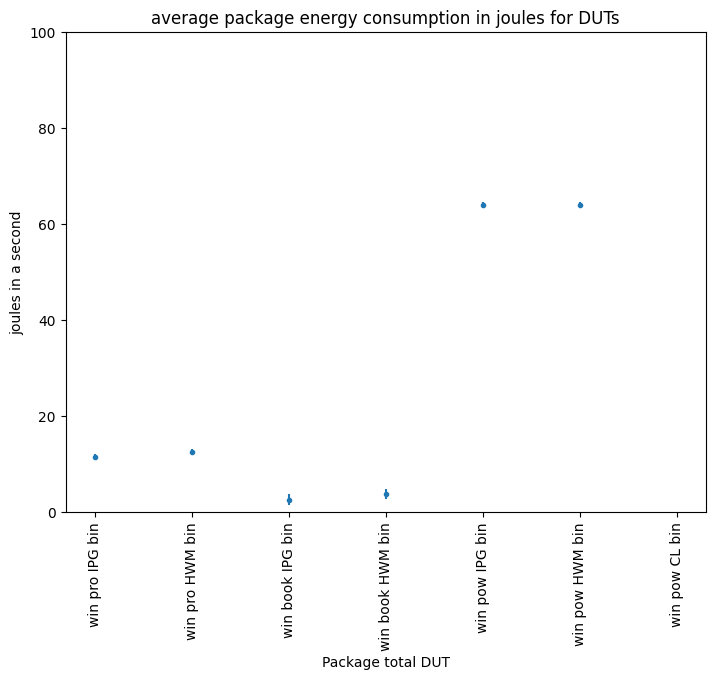

In [221]:
plot_comparison(PACKAGE_TOTAL, data, dynamic_energy, "Package total DUT", "joules in a second", "average package energy consumption in joules for DUTs")


### Dynamic energy consumption

A graph comparing the dram measuring made by different measuring instruments on the different DUTs

0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (-0.49303426883930185 - -0.1657580136628798)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (-0.47700667494271803 - -0.11320933806136535)
2 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (-0.22643451504653822 - -0.03492015096362)
3 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (-0.23111664944107302 - -0.022508258232816436)
4 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (-0.5325218635868817 - -0.11026808633390894)
5 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (-0.5303438685384214 - -0.4329816769130834)
6 - PowerKomplett, Win32NT, Clamp, BinaryTrees - sum of 120 (0 - 0)


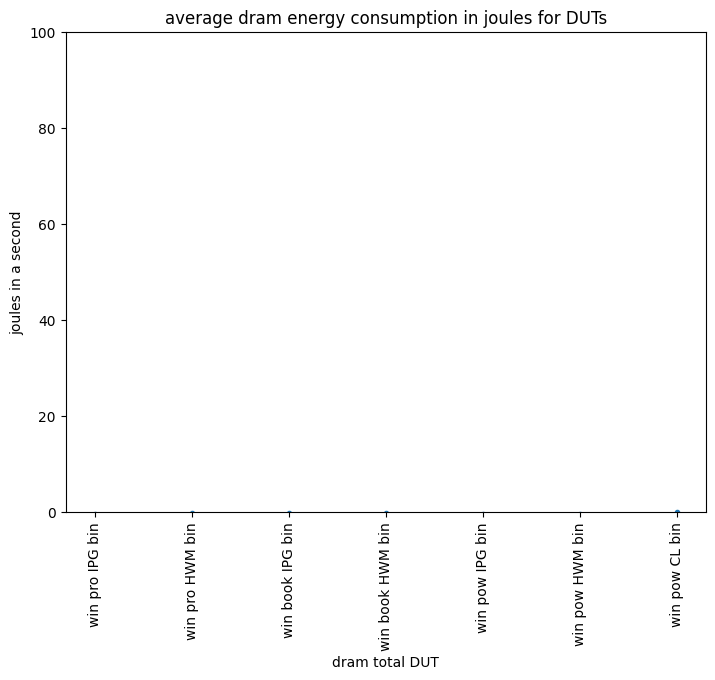

In [222]:
plot_comparison(DRAM_TOTAL, data, dynamic_energy, "dram total DUT", "joules in a second", "average dram energy consumption in joules for DUTs")

### Dynamic energy consumption

A graph comparing the core measuring made by different measuring instruments on the different DUTs

0 - Surface4Pro, Win32NT, IntelPowerGadget, BinaryTrees - sum of 122 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, Win32NT, HardwareMonitor, BinaryTrees - sum of 124 (10.844334061388246 - 12.222616294821524)
2 - SurfaceBook, Win32NT, IntelPowerGadget, BinaryTrees - sum of 127 (1.2670762584725308 - 5.172539407748209)
3 - SurfaceBook, Win32NT, HardwareMonitor, BinaryTrees - sum of 126 (1.3133641767411408 - 6.213910783042094)
4 - PowerKomplett, Win32NT, IntelPowerGadget, BinaryTrees - sum of 120 (62.628393540093064 - 68.65525045290848)
5 - PowerKomplett, Win32NT, HardwareMonitor, BinaryTrees - sum of 120 (64.08669133730693 - 68.19130097703922)
6 - PowerKomplett, Win32NT, Clamp, BinaryTrees - sum of 120 (-26.742858290505165 - -26.742858290505165)


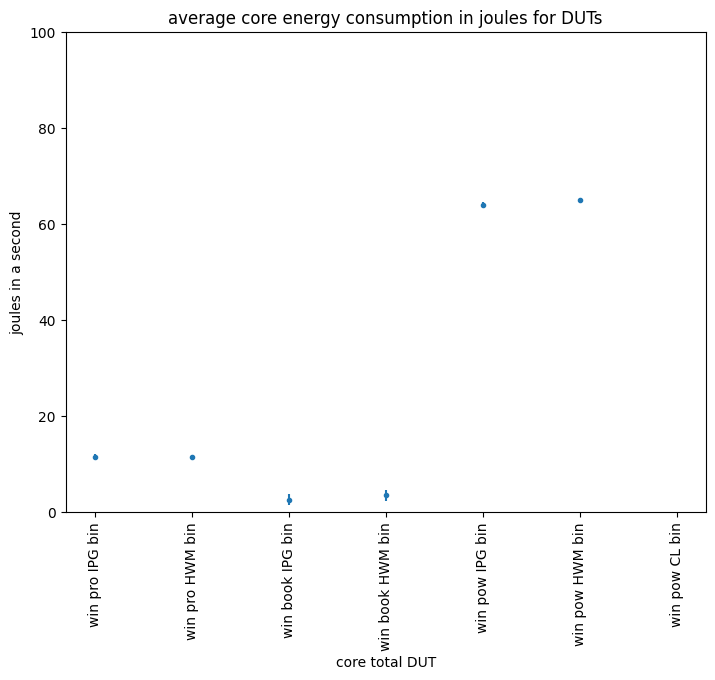

In [223]:
plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs")


### How R3 validation affects the energy consumtion

A graph presenting the the effect of which profiler was the first one to execute upon startup

0 - Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget, IntelPowerGadget - sum of 68 (9.699561483966681 - 12.75021977515838)
1 - Surface4Pro, BinaryTrees, Win32NT, IntelPowerGadget, HardwareMonitor - sum of 54 (10.209023847793171 - 12.744318013314507)
2 - Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor, IntelPowerGadget - sum of 67 (11.677571651488847 - 14.027043029580954)
3 - Surface4Pro, BinaryTrees, Win32NT, HardwareMonitor, HardwareMonitor - sum of 57 (11.157781461498026 - 14.11880520188684)
4 - SurfaceBook, BinaryTrees, Win32NT, IntelPowerGadget, IntelPowerGadget - sum of 73 (1.337519417353373 - 5.172539407748209)
5 - SurfaceBook, BinaryTrees, Win32NT, IntelPowerGadget, HardwareMonitor - sum of 54 (1.2670762584725308 - 5.004002902371618)
6 - SurfaceBook, BinaryTrees, Win32NT, HardwareMonitor, IntelPowerGadget - sum of 71 (1.515940938912102 - 6.0025974493007235)
7 - SurfaceBook, BinaryTrees, Win32NT, HardwareMonitor, HardwareMonitor - sum of 55 (1.9849522923317129 - 6.473499540

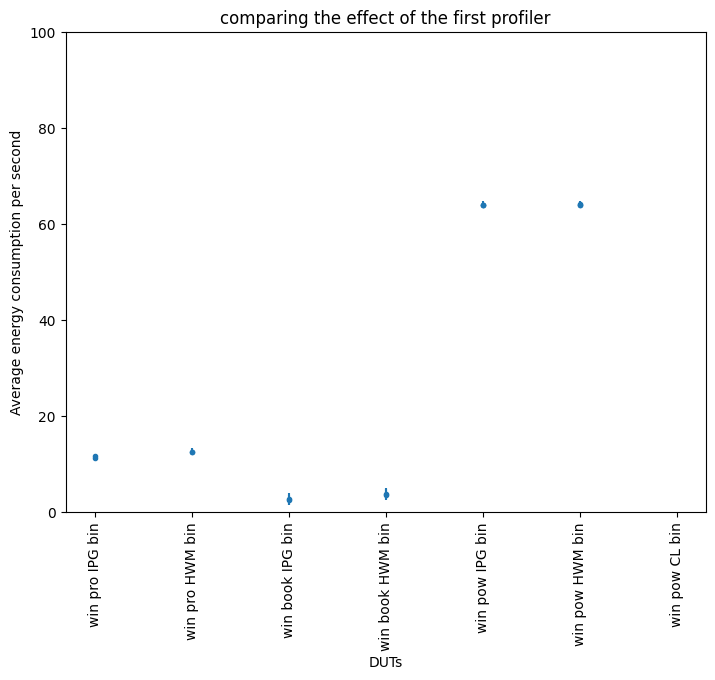

In [224]:
plot_first_profiler_comparison(PACKAGE_TOTAL, data, dynamic_energy, "DUTs", "Average energy consumption per second", "comparing the effect of the first profiler")

In [177]:
def get_iteration():
    for i in range(30):
        yield i
        
def is_correct_iteration(exp, value):
    return exp.iteration == value

### How time passed since a restart effects energy consumptionn

A graph presenting the relationship between the iteration since a system restart, and how it affects the energy consumption

Surface4Pro - BinaryTrees - Win32NT - IntelPowerGadget
Surface4Pro - BinaryTrees - Win32NT - HardwareMonitor
SurfaceBook - BinaryTrees - Win32NT - IntelPowerGadget
SurfaceBook - BinaryTrees - Win32NT - HardwareMonitor
PowerKomplett - BinaryTrees - Win32NT - IntelPowerGadget
PowerKomplett - BinaryTrees - Win32NT - HardwareMonitor


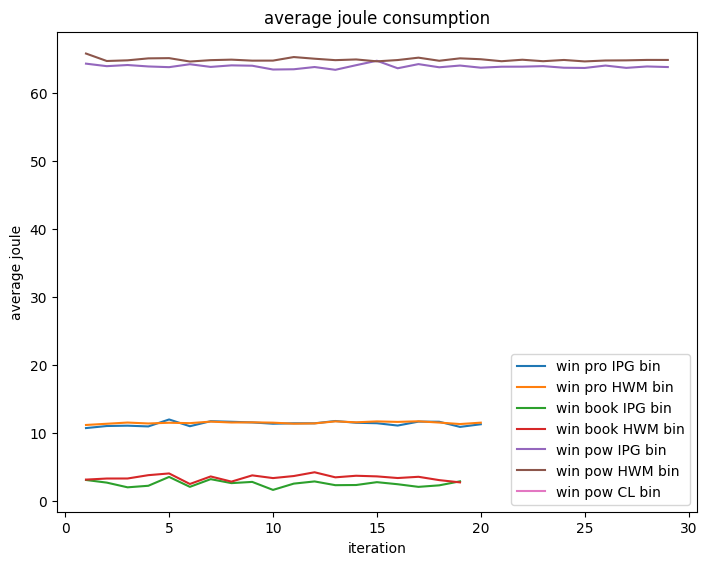

In [226]:
plot_iterations(CORE_TOTAL, get_iteration, is_correct_iteration, "iteration", "average joule", "average joule consumption", data, dynamic_energy)

In [175]:
def get_buckets():
    min_bucket = 0
    max_bucket = 100
    bucket_size = 5

    last_value = 0

    for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
        # print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
        yield (last_value, i)
        last_value = i

def is_correct_temperature(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_temperature.data]
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp > min_value and avg_temp < max_value

### Temperatures levels effect on energy consumption

A graph presenting the relationship between the temperature and energy consumption

Surface4Pro - BinaryTrees - Win32NT - IntelPowerGadget
Surface4Pro - BinaryTrees - Win32NT - HardwareMonitor
SurfaceBook - BinaryTrees - Win32NT - IntelPowerGadget
SurfaceBook - BinaryTrees - Win32NT - HardwareMonitor
PowerKomplett - BinaryTrees - Win32NT - IntelPowerGadget
PowerKomplett - BinaryTrees - Win32NT - HardwareMonitor


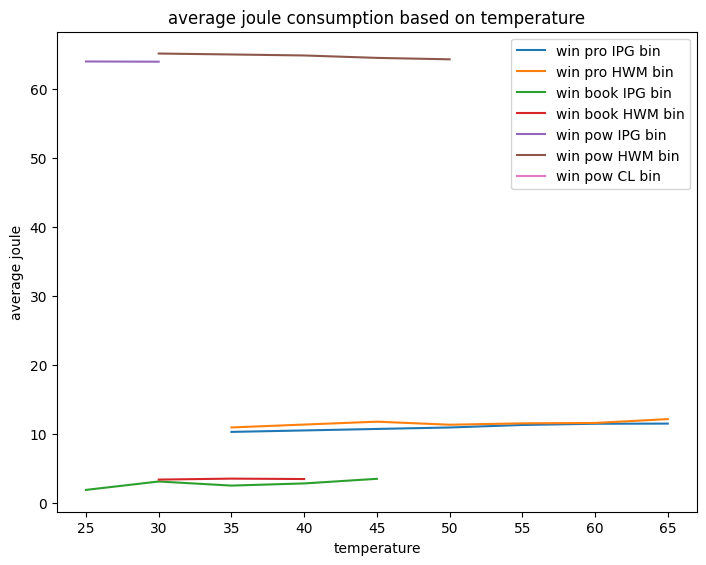

In [227]:
plot_iterations(CORE_TOTAL, get_buckets, is_correct_temperature, "temperature", "average joule", "average joule consumption based on temperature", data, dynamic_energy)

In [173]:
def is_correct_charge(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_battery.data]
    
    if len(temp) == 0:
        return False
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp >= min_value and avg_temp < max_value

### Battery levels effect on energy consumption

A graph presenting the relationship between the battery level and energy consumption

Surface4Pro - BinaryTrees - Win32NT - IntelPowerGadget
Surface4Pro - BinaryTrees - Win32NT - HardwareMonitor
SurfaceBook - BinaryTrees - Win32NT - IntelPowerGadget
SurfaceBook - BinaryTrees - Win32NT - HardwareMonitor


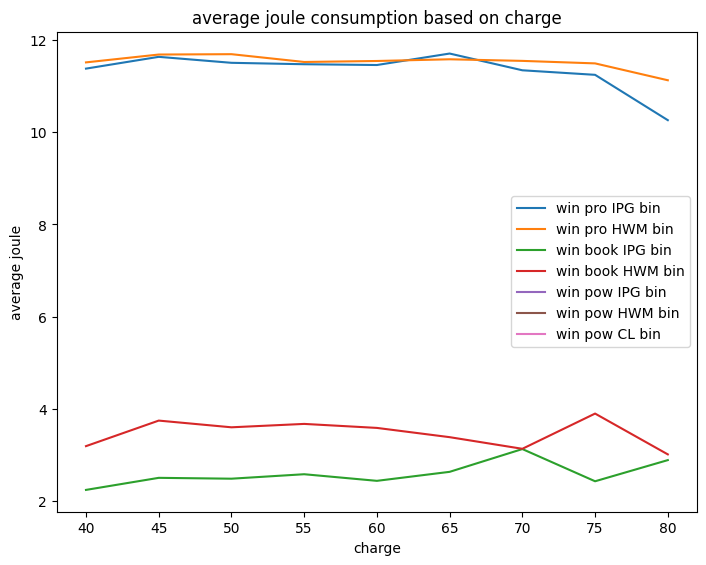

In [228]:
plot_iterations(CORE_TOTAL, get_buckets, is_correct_charge, "charge", "average joule", "average joule consumption based on charge", data, dynamic_energy)


In [245]:
intel_power_gadget_data_point = data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][INTEL_POWER_GADGET]["experiment"].experiments[0].time_series.data_point[0]
inspect.getmembers(intel_power_gadget_data_point, lambda a:not(inspect.isroutine(a)))

[('CPUFrequency_0MHz', ' 3200'),
 ('CPUUtilization', '   71.000'),
 ('CumulativeDRAMEnergy_0Joules', '   0.113'),
 ('CumulativeDRAMEnergy_0mWh', '   0.031'),
 ('CumulativeGTEnergy_0Joules', '   0.026'),
 ('CumulativeGTEnergy_0mWh', '   0.007'),
 ('CumulativeIAEnergy_0Joules', '   1.830'),
 ('CumulativeIAEnergy_0mWh', '   0.508'),
 ('CumulativeProcessorEnergy_0Joules', '   2.177'),
 ('CumulativeProcessorEnergy_0mWh', '   0.605'),
 ('DRAMPower_0Watt', '   0.875'),
 ('ElapsedTimesec', '    0.129'),
 ('GTFrequencyMHz', 32),
 ('GTPower_0Watt', '   0.203'),
 ('GTUtilization', '   4.897'),
 ('IAPower_0Watt', '  14.175'),
 ('PackageHot_0', '  0'),
 ('PackagePL1_0Watt', '  25.000'),
 ('PackagePL2_0Watt', '  25.000'),
 ('PackagePL4_0Watt', '  46.000'),
 ('PackageTemperature_0C', ' 68'),
 ('PlatformPsysPL1_0Watt', '  45.000'),
 ('PlatformPsysPL2_0Watt', '  45.000'),
 ('ProcessorPower_0Watt', '  16.871'),
 ('RDTSC', ' 12063536978770'),
 ('SystemTime', '06:49:56:760'),
 ('__class__', utils.objects.

In [244]:
intel_power_gadget_data_point.SystemTime, intel_power_gadget_data_point.CumulativeProcessorEnergy_0Joules

('06:49:56:760', '   2.177')

In [249]:
hardware_monitor_data_point = data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][HARDWARE_MONITOR]["experiment"].experiments[0].time_series.data_point[0]
inspect.getmembers(hardware_monitor_data_point, lambda a:not(inspect.isroutine(a)))

[('__class__', utils.objects.DataPoint),
 ('__delattr__',
  <method-wrapper '__delattr__' of DataPoint object at 0x000002B788A51ED0>),
 ('__dict__',
  {'time': '2022-11-19T05:51:05.0470551Z',
   'avgLoad': 56.343742,
   'totalLoad': 56.343746,
   'cpuC1T1': 54.489414,
   'cpuC1T2': 56.708443,
   'cpuC2T1': 58.1467,
   'cpuC2T2': 56.030403,
   'cpuC3T1': -1,
   'cpuC3T2': -1,
   'cpuC4T1': -1,
   'cpuC4T2': -1,
   'cpuC5T1': -1,
   'cpuC5T2': -1,
   'cpuC6T1': -1,
   'cpuC6T2': -1,
   'cpuMaxTemp': 71,
   'cpuAvgTemp': 68,
   'cpuC1Temp': 71,
   'cpuC2Temp': 65,
   'cpuC3Temp': -1,
   'cpuC4Temp': -1,
   'cpuC5Temp': -1,
   'cpuC6Temp': -1,
   'cpuC1Clock': 3211.6377,
   'cpuC2Clock': 3211.6377,
   'cpuC3Clock': -1,
   'cpuC4Clock': -1,
   'cpuC5Clock': -1,
   'cpuC6Clock': -1,
   'cpuBusSpeed': 100.36368,
   'cpuPowerPacket': 13.43288,
   'cpuPowerCores': 11.066739,
   'cpuPowerMemory': 0.5226537,
   'cpuVoltageCores': 1.0943604,
   'cpuVoltageC1': 1.0297852,
   'cpuVoltageC2': 1.02954

In [251]:
hardware_monitor_data_point.time, hardware_monitor_data_point.totalLoad

('2022-11-19T05:51:05.0470551Z', 56.343746)

In [263]:
def plot_timestamp(timestamps, values):
    plt.plot(timestamps,values)
    plt.gcf().autofmt_xdate()
    plt.show()

In [261]:
data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][HARDWARE_MONITOR]["experiment"].experiments[0].time_series.data_point[0]

In [269]:
from datetime import datetime

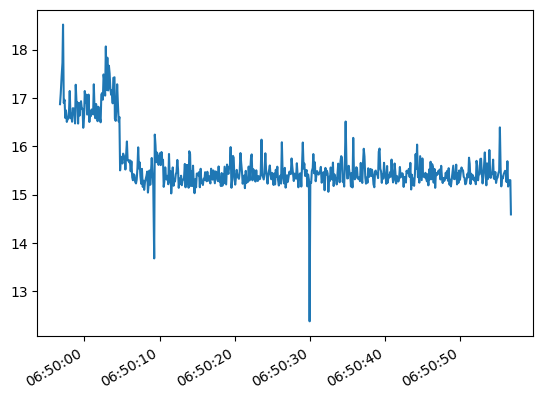

In [273]:
intel_power_gadget_data_points = data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][INTEL_POWER_GADGET]["experiment"].experiments[0].time_series.data_point

intel_power_gadget_timestamps = [datetime.strptime(x.SystemTime, "%H:%M:%S:%f") for x in intel_power_gadget_data_points]
intel_power_gadget_values = [float(x.ProcessorPower_0Watt) for x in intel_power_gadget_data_points]

plot_timestamp(intel_power_gadget_timestamps, intel_power_gadget_values)


In [302]:
def trim_date(date):
    date = date.replace("T", " ")
    date = date.replace("Z", " ")
    return date[:-3]

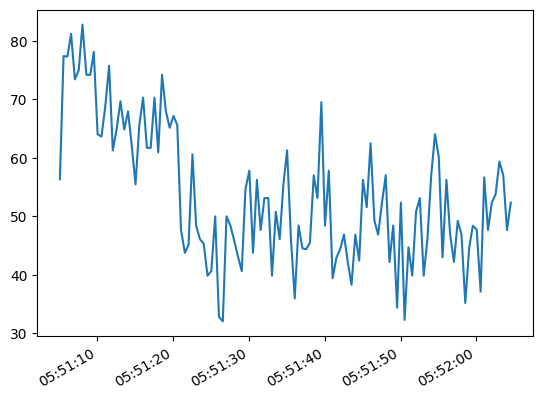

In [303]:
intel_power_gadget_data_points = data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][HARDWARE_MONITOR]["experiment"].experiments[0].time_series.data_point

intel_power_gadget_timestamps = [datetime.strptime(trim_date(x.time), "%Y-%m-%d %H:%M:%S.%f") for x in intel_power_gadget_data_points]
intel_power_gadget_values = [float(x.totalLoad) for x in intel_power_gadget_data_points]

plot_timestamp(intel_power_gadget_timestamps, intel_power_gadget_values)
## 2022-11-19T05:51:05.0470551Z